# Orthogonal Learning

## Simulation Design 1

In [1]:
using Distributions
using DataFrames
using CSV
using Tables
using Lathe
using GLM
using CovarianceMatrices

using Gadfly

In [2]:
using Random
Random.seed!(1234)

MersenneTwister(1234)

In [3]:
#importamos hdmjl
include("../Julia_Notebooks/hdmjl/hdmjl.jl")

In [4]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B);

In [5]:
#codigo correcto

n = 10000
p = 100
beta = 1/(1:p).^2
gamma = 1/(1:p).^2

X = rand(Normal(0,1),n,p)
D = X * transpose(gamma) + (rand(Normal(0,1),n,1)/4)
Y = D + X * transpose(beta) + rand(Normal(0,1),n,1);

X1 = hcat(D,X)
model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
coef1 = rlasso(model1)["coefficients"][3:102,2]
SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )

if (sum(coef1[SX_IDs,:])==0) 
    Y1 = DataFrame(hcat(Y,D),["Y","D"])
    print(coef(lm(@formula(Y ~ D), Y1))[2]) #enlace con Naive
end

if (sum(coef1[SX_IDs,:])>0) 
    Y2 = DataFrame(hcat(Y,D,X[:,SX_IDs]),["Y","D","Xi"])
    print(coef(lm(@formula(Y ~ D + Xi), Y2))[2]) #enlace con Naive
end

model2 =rlasso_arg( X, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
model3 =rlasso_arg( X, D ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true );

resY = rlasso(model2)["residuals"]
resD = rlasso(model3)["residuals"]
Y3=DataFrame(hcat(resY,resD),["resY","resD"])
coef(lm(@formula(resY ~ resD), Y3))[2] #enlace orthogonal


1.045339043828092

1.0453390438280918

In [6]:

for i in 1:B
    n = 10000
    p = 100
    beta = 1/(1:p).^2
    gamma = 1/(1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * transpose(gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 5*D + X * transpose(beta) + rand(Normal(0,1),n,1);

    X1 = hcat(D,X)
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = DataFrame(hcat(Y,D),["Y","D"])
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] 
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Y2 = DataFrame(hcat(Y,D,X[:,SX_IDs]),["Y","D","Xi"])
        Naive[i] = coef(lm(@formula(Y ~ D + Xi), Y2))[2]
    end

    model2 =rlasso_arg( X, Y ,nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] 

end





In [7]:
results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])


,Naive,Orthogonal
,Float64,Float64
1,5.00343,5.00343
2,4.95982,4.95982
3,5.06324,5.06246
4,4.98469,4.98469
5,4.9682,4.9682
6,5.04722,5.04722
7,4.95401,4.95401
8,4.99548,4.99548
9,5.03209,5.03209


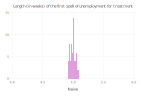

In [19]:
Gadfly.plot(results, Coord.cartesian(xmin=4, xmax=6),
    layer(x = "Naive", Geom.histogram(bincount=1000, density=true, limits=(min=0,)),
    color=[colorant"plum"]),
    Guide.title("Length (in weeks) of the first spell of unemployment for treatment")
)